In [118]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path

In [119]:
def dump_df(df):
    # Tem que usar essa opção pro pandas imprimir a saída toda, mas não queriamos definir isso pro arquivo inteiro
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "display.max_colwidth", None):
        print(df)

In [120]:
DATA_PATH = './data/glycemic_index/foods.csv'
df = pd.read_csv(DATA_PATH, delimiter=';').drop_duplicates().set_index('id')
df

,name,category,sample_amount,sample_unit,calories_kcal,calories_kj,protein,carbohydrates,fats,glycemic_index,glycemic_load
id,,,,,,,,,,,
baguette-white,Baguette (white),Baked products,100,grams,240.0,1004,7.5,49.0,2.5,95.0,46.5
baguette-whole-grain,Baguette (whole grain),Baked products,100,grams,219.0,916,6.3,38.8,1.2,73.0,28.3
bagel-wheat,Bagel (wheat),Baked products,100,grams,257.0,1075,10.0,50.5,1.6,70.0,35.4
biscuit,Biscuit,Baked products,100,grams,365.0,1527,6.2,48.5,16.5,70.0,34.0
biscotti-dry-cookies,Biscotti (dry cookies),Baked products,100,grams,358.0,1498,6.0,50.0,15.0,70.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...
tapioca-dried,Tapioca (dried),Other,100,grams,350.0,1464,0.2,87.8,0.0,85.0,74.6
taro,Taro,Other,100,grams,112.0,469,1.5,26.5,0.2,48.0,12.7
tahin,Tahin,Other,100,grams,595.0,2489,17.0,21.0,54.0,40.0,8.4


In [121]:
df.groupby('category').count()['name']

category
Baked products      49
Beverages           28
Dairy               44
Fast foods           9
Fruits              80
Grains             104
Greens              50
Meat                32
Mushrooms            2
Nuts                17
Oils and sauces     16
Other               16
Seafood              5
Soups                5
Spices              24
Sweets              42
Vegetables          55
Name: name, dtype: int64

In [133]:
# Criando as variáveis real_calories e carbs_kcal_perc

df['real_calories'] = df['carbohydrates'] * 4 + df['protein'] * 4 + df['fats'] * 9
df['carbs_kcal_perc'] = df['carbohydrates'] * 4 / df['real_calories']

# real_calories = 0, então carbs_kcal_perc ficou como NaN. Como é apenas um elemento, preferi corrigir manualmente.
df.loc['vinegar', 'carbs_kcal_perc'] = 0.0

# Criando a variável real_gl
df['real_gl'] = (df['glycemic_index'] * df['carbohydrates']) / 100

Vamos dar mais foco no GL no restante do relatório, visto que, como seus valores já são normalizados para a quantidade de carboidratos de uma porção, ele reflete melhor o efeito de um determinado alimento ao ser consumido.

## Teste de hipótese
Como observado anteriormente, categorias onde os alimentos são majoritariamente compostos de carboidratos e gorduras parecem ter GL mais alto. Para testar essa hipótese, podemos fazer um teste de permutação: embaralhamos as categorias dos alimentos, calculamos as médias e vemos se os valores que encontramos originalmente podem ser explicados pelo acaso ou se são de fato raros de se acontecer, implicando que nossa tese tem validade.

- Hipótese nula: (H0): As GLs médias das categorias que observamos pode ocorrer ao acaso
- Hipótese alternativa (HA): Alimentos com maior fração de carboidratos em sua composição têm maior GL, na média.

In [123]:
# Realizando testes de permutação
N = 10000
categorias = df.groupby('category').count().index
n_categorias = len(categorias)

df_permutacao = df[['category', 'glycemic_load']].copy()

medias = np.zeros((N, n_categorias))

for i in range(N):
    np.random.shuffle(df_permutacao['category'].values)
    medias[i] = (df_permutacao
        [['category', 'glycemic_load']]
        .groupby('category')
        .mean()
        ['glycemic_load']
    )

Baked products : IC (95%) = [10.4488, 20.3939] | t_obs = 32.0082


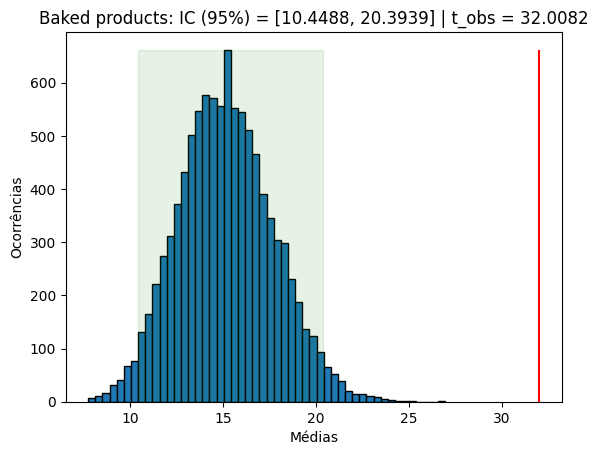

Beverages      : IC (95%) = [ 8.8927, 22.3358] | t_obs = 4.5250


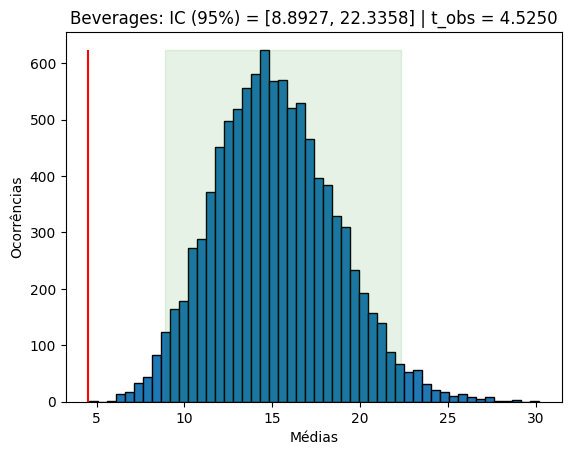

Dairy          : IC (95%) = [10.1500, 20.8956] | t_obs = 3.8273


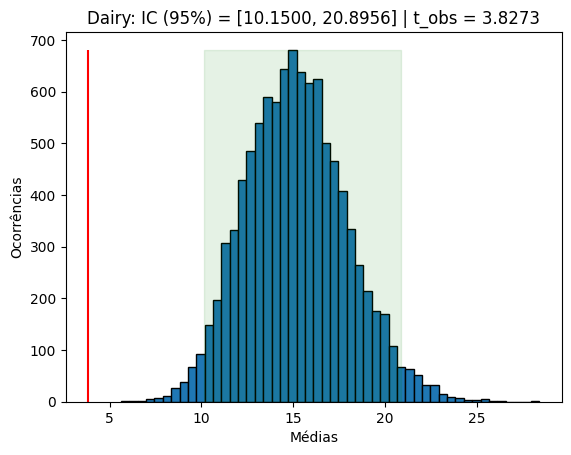

Fast foods     : IC (95%) = [ 4.7553, 29.1333] | t_obs = 30.5556


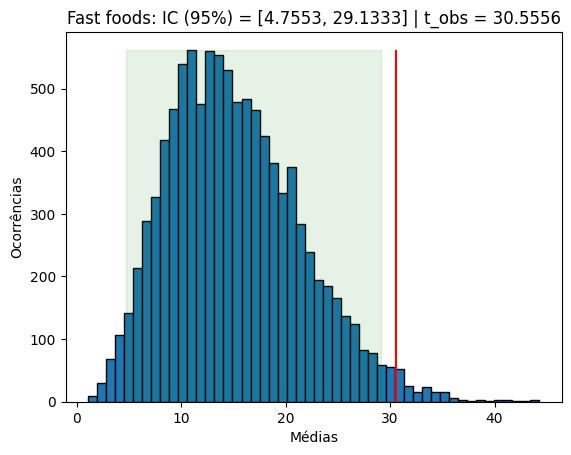

Fruits         : IC (95%) = [11.3535, 19.1238] | t_obs = 10.3750


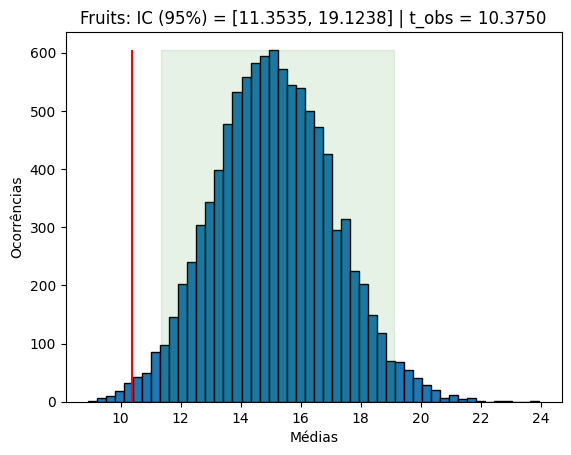

Grains         : IC (95%) = [11.9529, 18.5972] | t_obs = 28.6125


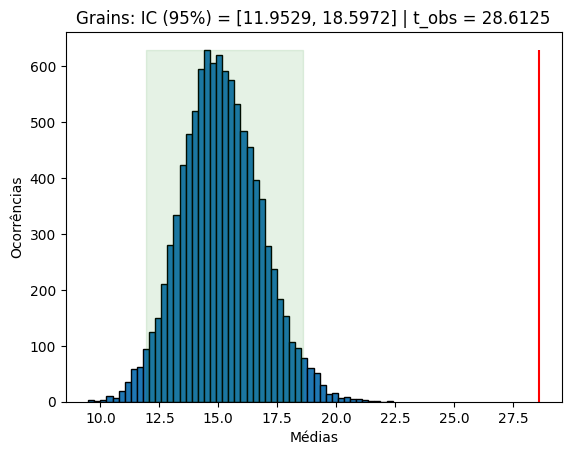

Greens         : IC (95%) = [10.4520, 20.4001] | t_obs = 7.3640


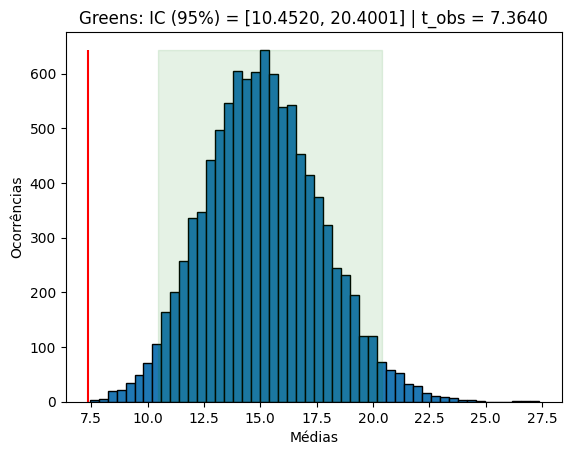

Meat           : IC (95%) = [ 9.2000, 22.0191] | t_obs = 0.8500


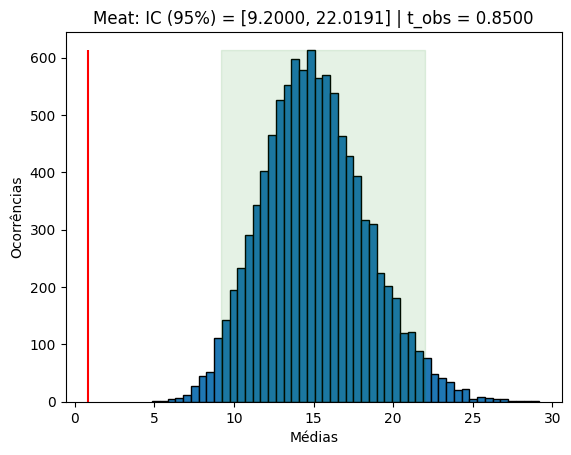

Mushrooms      : IC (95%) = [ 0.3988, 48.8537] | t_obs = 1.3500


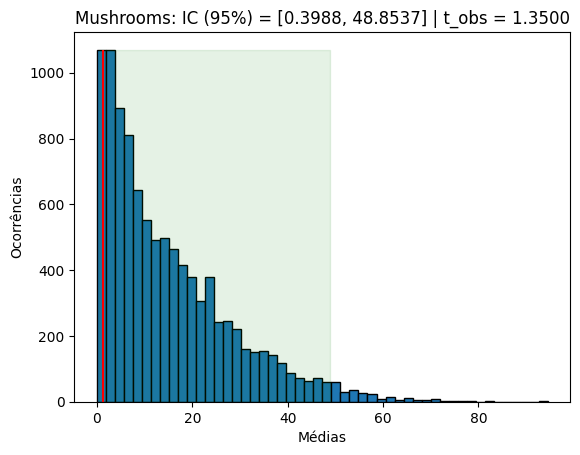

Nuts           : IC (95%) = [ 7.1469, 24.7588] | t_obs = 8.0294


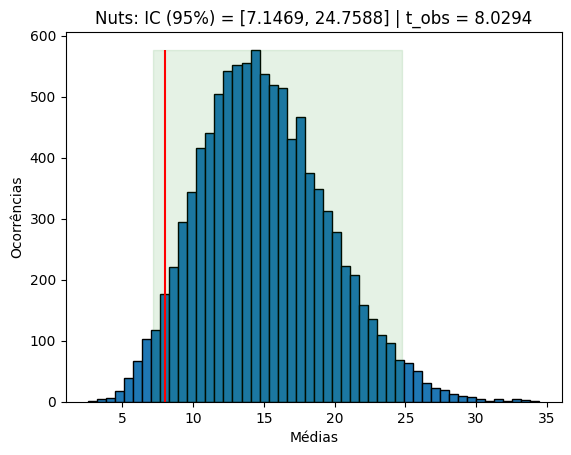

Oils and sauces: IC (95%) = [ 7.1312, 24.9062] | t_obs = 1.0188


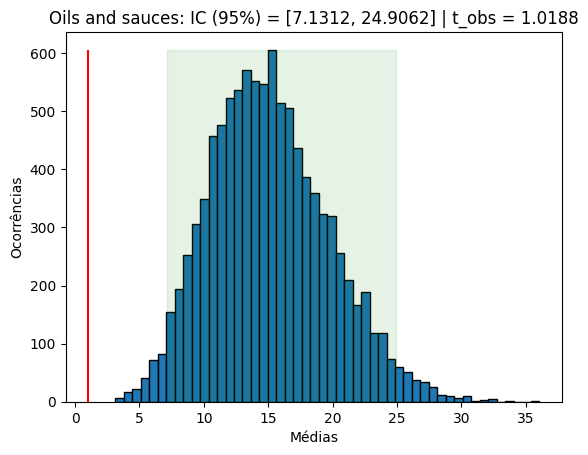

Other          : IC (95%) = [ 7.0218, 25.4191] | t_obs = 18.5875


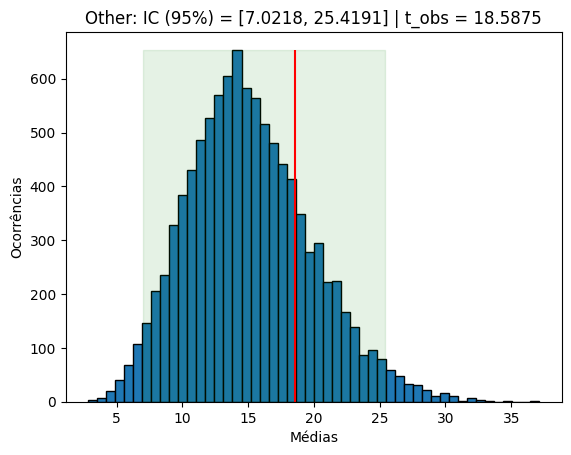

Seafood        : IC (95%) = [ 2.5400, 34.2000] | t_obs = 0.7000


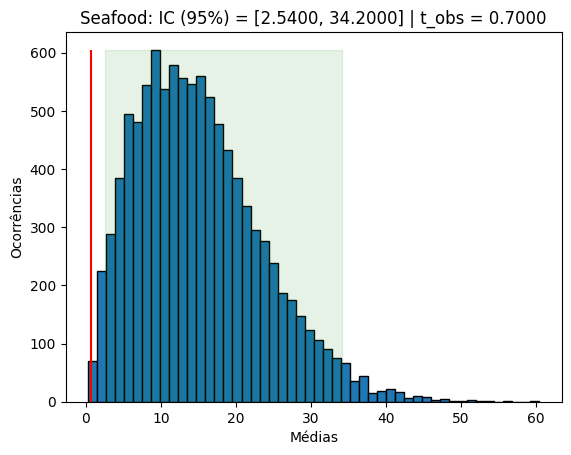

Soups          : IC (95%) = [ 2.5395, 34.2000] | t_obs = 2.9800


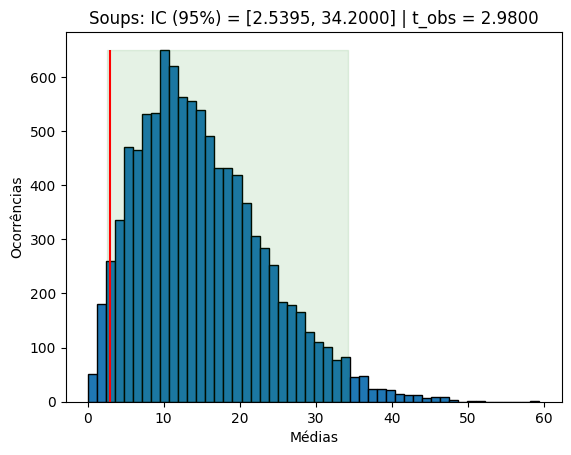

Spices         : IC (95%) = [ 8.4061, 23.1751] | t_obs = 5.0667


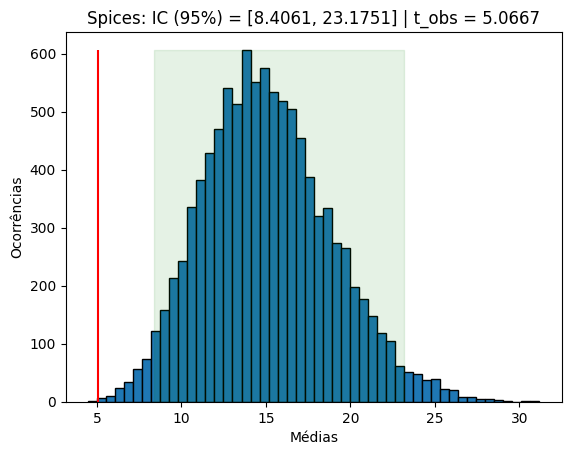

Sweets         : IC (95%) = [ 9.9761, 21.0168] | t_obs = 38.5524


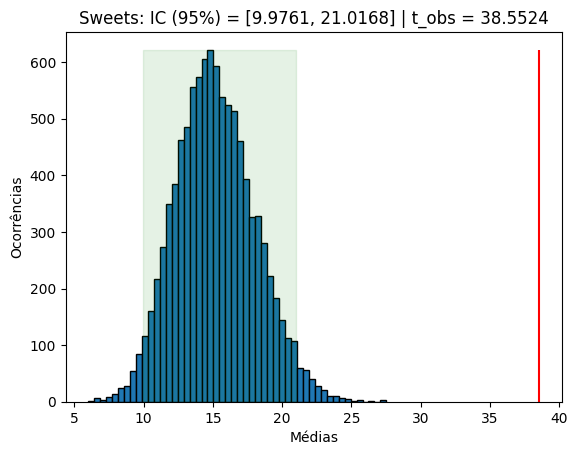

Vegetables     : IC (95%) = [10.5563, 20.0039] | t_obs = 3.4991


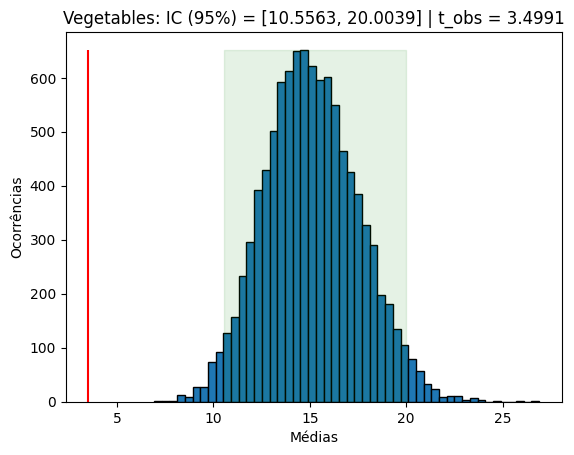

In [124]:
# Realizando ICs separadas para cada categoria

medias_originais = (df
    [['category', 'glycemic_load']]
    .groupby('category')
    .mean()
    ['glycemic_load'])

graficos = []

for i, categoria in enumerate(categorias):
    confianca_inf = np.percentile(medias[:, i], 2.5)
    confianca_sup = np.percentile(medias[:, i], 97.5)
    print(f'{categoria:15}: IC (95%) = [{confianca_inf:7.4f}, {confianca_sup:7.4f}] | t_obs = {medias_originais[categoria]:.4f}')
    height, *_ = plt.hist(medias[:, i], bins=50, edgecolor='k')
    plt.xlabel(f'Médias')
    plt.ylabel('Ocorrências')
    plt.title(f'{categoria}: IC (95%) = [{confianca_inf:.4f}, {confianca_sup:.4f}] | t_obs = {medias_originais[categoria]:.4f}')
    plt.vlines(medias_originais[categoria], 0, height.max(), color='red')
    plt.fill_betweenx([0, height.max()], confianca_inf, confianca_sup, color='g', alpha=0.1)
    # plt.text(t_obs+1, 0.10, '$16\%$ dos casos')
    # despine()
    plt.show()

Executamos diversos intervalos de confiança, e podemos notar que, na maioria deles, os valores observados estão fora do intervalo de confiança, o que nos permite rejeitar a hipótese nula de que os valores que observamos são explicados pelo acaso. Isso nos dá mais confiança de que nossa hipótese alternativa está correta, e que alimentos onde a maior parte das calorias vem de carboidratos e gorduras têm GL maior, sendo assim alimentos que devem ser evitados por pessoas com diabetes.

- Os casos em que os valores estão dentro do IC podem ser facilmente explicados pelo número de elementos: categorias como Sopas, Frutos do mar e Cogumelos são muito pequenas (5, 5 e 2 alimentos, respectivamente). Isso aumenta a variabilidade das médias, alargando os Intervalos de Confiança para cobrir uma faixa de valores maior, que acabam incluindo nossas médias observadas.

## Modelos de regressão

Além das análises exploratórias que fizemos dos dados, o nosso teste de hipótese nos confirmou que de fato há uma correlação entre a composição em macronutrientes do alimento (em especial carboidratos e gorduras) e o GL dele. Com base nesses indícios, podemos treinar um modelo de regressão para prever o valor do GL de um alimento a partir de suas informações nutricionais.

Inicialmente, tentamos duas abordagens: uma regressão múltipla com regularização L2, uma regressão baseada em vizinhos mais próximos, e uma regressão usando Random Forest, um modelo não estudado no curso (porém brevemente visto em uma das listas). As features escolhidas para compor o modelo foram:

- A quantidade de calorias da amostra (para uma amostra de 100g, que é o caso de todas as amostras presentes)
- A porcentagem das calorias que é proveniente de carboidratos
- A quantidade de carboidratos da amostra (em gramas)
- A quantidade de proteínas da amostra (em gramas)
- A quantidade de gorduras da amostra (em gramas)
  
Utilizamos também a validação cruzada para evitar um overfitting dos nossos dados, na busca de encontrar um modelo que generalize melhor. Abaixo estão os resultados que encontramos, utilizando a biblioteca SciKit Learn.

In [149]:
# Definições base para testar modelos
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold

In [159]:
# Testando modelos para prever o GL (glycemic_load)

features = ['real_calories', 'carbs_kcal_perc', 'carbohydrates', 'protein', 'fats']
resposta = 'glycemic_load'

X_gl = df[features]
y_gl = df[resposta]
skf_gl = KFold(n_splits=5)

X_y_train, X_y_test, y_gl_train, y_gl_test = train_test_split(X_gl, y_gl, test_size=0.20)


# Regressão Múltipla com Regularização L2, utilizando real_calories
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=skf_gl).fit(X_y_train, y_gl_train)
print('Regressão Múltipla  com regularização L2')
print(f'Coeficientes: {ridge.coef_}')
print(f'Intercepto: {ridge.intercept_}')
print(f'Alpha da regularização: {ridge.alpha_}')
print(f'R2 da Regressão Polinomial: {ridge.score(X_y_test, y_gl_test)}\n')

# Regressão KNN, utilizando real_calories
n_neighbors = 7
knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_y_train, y_gl_train)
print('Regressão KNN')
print(f'Número de vizinhos: {n_neighbors}')
print(f'R2 do KNN: {knn.score(X_y_test, y_gl_test)}\n')

# Regressão com RandomForest
n_estimators=100
max_depth=None
rfr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth).fit(X_y_train, y_gl_train)
print('Regressão com Random Forest')
print(f'Número de estimadores: {n_estimators}')
print(f'R2 do Random Forest: {rfr.score(X_y_test, y_gl_test)}\n')

Regressão Múltipla  com regularização L2
Coeficientes: [ 0.00751615 -5.38789022  0.61571854 -0.3404664  -0.12149915]
Intercepto: 2.6065011410833208
Alpha da regularização: 1.0
R2 da Regressão Polinomial: 0.6854891943827807

Regressão KNN
Número de vizinhos: 7
R2 do KNN: 0.5635411565731334

Regressão com Random Forest
Número de estimadores: 100
R2 do Random Forest: 0.49046433988239013



Regressão Múltipla com regularização L2
- Coeficientes: [ 0.01110037  0.54678867 -0.26619931 -0.10173302]
- Intercepto: -0.5130038517747195
- Alpha da regularização: 1.0
- R2 da Regressão Polinomial: 0.831997858888091

Regressão KNN
- Número de vizinhos: 7
- R2 do KNN: 0.8283365130501471

Regressão com Random Forest
- Número de estimadores: 100
- R2 do Random Forest: 0.8299958861673788


Olhando para o valor do R2 de cada um dos modelos, avaliado nos dados de teste, vemos que a regressão múltipla se saiu melhor que o KNN e o RFR, e por isso escolhemos esse modelo para prosseguir.

Para melhorar o nosso modelo, utilizamos a biblioteca statsmodels, pois ela nos apresenta resultados mais detalhados, que facilitam a criação de um modelo mais polido.

In [163]:
import statsmodels.api as sm

X_gl = df[features]
y_gl = df[resposta]

X_c = sm.add_constant(X_gl)
X_c_train, X_c_test, y_c_gi_train, y_c_gi_test = train_test_split(X_c, y_gl, test_size=0.20)

model2 = sm.OLS(y_c_gi_train, X_c_train)
resultado = model2.fit()
resultado.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          glycemic_load   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     386.7
Date:                dom, 18 ago 2024   Prob (F-statistic):          3.70e-145
Time:                        00:58:58   Log-Likelihood:                -1684.0
No. Observations:                 462   AIC:                             3378.
Df Residuals:                     457   BIC:                             3399.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.3097      1.699      1.948      0.052      -0.029       6.648
real_calories       0.0055      0.004      1.464      0.144      -0.002       0.013
carbs_kcal_perc    -6.1753      2.370     -2.606      0.009     -10.832      -1.519
carbohydrates       0.6306      0.029     21.988      0.000       0.574       0.687
protein            -0.3877      0.062     -6.269      0.000      -0.509      -0.266
fats               -0.1074      0.022     -4.906      0.000      -0.150      -0.064
==============================================================================
Omnibus:                       70.545   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              795.365
Skew:                           0.047   Prob(JB):                    1.94e-173
Kurtosis:                       9.427   Cond. No.                     2.18e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.91e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

O relatório de regressão acima, gerado com a biblioteca statsmodels, mostra os intervalos de confiança para os coeficientes da nossa regressão. Os intervalos que contém o valor 0 correspondem a features que podem possivelmente ser eliminadas do nosso modelo, para reduzir a variância e encontrar um modelo que generalize melhor. Neste caso, o relatório diz que a variável real_calories pode ser eliminada. Nos gráficos abaixo, podemos comparar os dois modelos.
- A primeira linha é referente ao modelo com a feature real_calories, enquanto na segunda linha a feature foi removida.
- Nos gráficos da esquerda, o eixo x indica o valor observado na amostra, enquanto o eixo y indica o valor previsto pelo modelo, ou seja, quanto mais próximos os pontos azuis estiverem da reta vermelha y=x, melhor o modelo conseguiu prever os dados. Se o ponto estiver acima da reta, o modelo previu um valor maior do que o observado, e o contrário se o ponto estiver abaixo da reta.
- Nos gráficos da direita, as amostras foram ordenadas pelo GL. Assim, o eixo x é apenas o id da amostra, e o eixo y indica o valor do GL. A curva azul corresponde às amostras, e a curva laranja representa as previsões do modelo para cada ponto. Quanto mais próxima a curva laranja estiver da azul, mais próximo o modelo está dos dados. Novamente, se um ponto laranja estiver acima da curva azul, o modelo previu um valor maior do que o observado, e o contrário se o ponto estiver abaixo da curva azul.

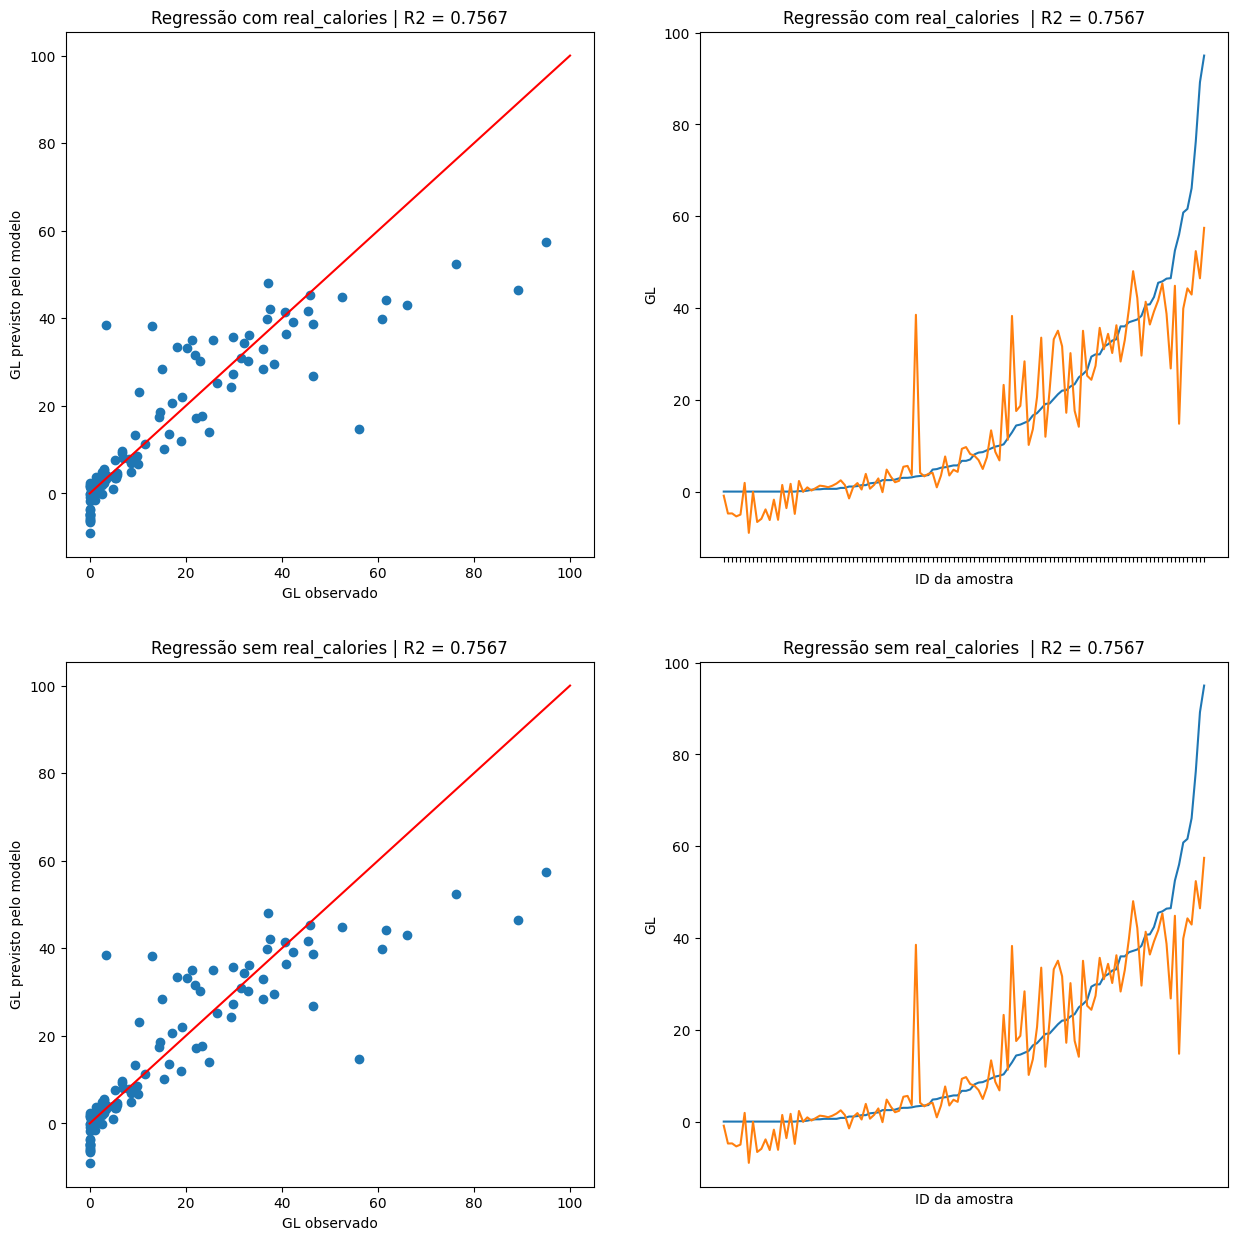

In [195]:
features_a = ['real_calories', 'carbs_kcal_perc', 'carbohydrates', 'protein', 'fats']
features_b = ['carbs_kcal_perc', 'carbohydrates', 'protein', 'fats']
resposta = 'glycemic_load'

X_y_train, X_y_test, y_train, y_test = train_test_split(df, df[resposta], test_size=0.20)
X_a_train = X_y_train[features_a].copy()
X_b_train = X_y_train[features_b].copy()
skf_gl = KFold(n_splits=5)

ridge_a = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=skf_gl).fit(X_a_train, y_train)
ridge_b = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=skf_gl).fit(X_b_train, y_train)


X_y_test_ordenado = X_y_test.sort_values(by=resposta)
X_a_test_ordenado = X_y_test_ordenado[features_a]
X_b_test_ordenado = X_y_test_ordenado[features_b]
y_test_ordenado = X_y_test_ordenado[resposta]

previsoes_a = ridge_a.predict(X_a_test_ordenado)
previsoes_b = ridge_b.predict(X_b_test_ordenado)

r2_a = ridge_a.score(X_a_test_ordenado, y_test_ordenado)
r2_b = ridge_b.score(X_b_test_ordenado, y_test_ordenado)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
x = np.linspace(0, 100)

axs[0, 0].set_title(f"Regressão com real_calories | R2 = {r2_a:.4f}")
axs[0, 0].set_xlabel("GL observado")
axs[0, 0].set_ylabel("GL previsto pelo modelo")
axs[0, 0].scatter(x=y_test_ordenado, y=previsoes_a)
axs[0, 0].plot(x, x, color='r')

axs[0, 1].set_title(f"Regressão com real_calories  | R2 = {r2_a:.4f}")
axs[0, 1].set_xlabel("ID da amostra")
axs[0, 1].set_ylabel("GL")
axs[0, 1].set_xticklabels([])
axs[0, 1].plot(y_test_ordenado)
axs[0, 1].plot(previsoes_a)

axs[1, 0].set_title(f"Regressão sem real_calories | R2 = {r2_b:.4f}")
axs[1, 0].set_xlabel("GL observado")
axs[1, 0].set_ylabel("GL previsto pelo modelo")
axs[1, 0].scatter(x=y_test_ordenado, y=previsoes_b)
axs[1, 0].plot(x, x, color='r')

axs[1, 1].set_title(f"Regressão sem real_calories  | R2 = {r2_b:.4f}")
axs[1, 1].set_xlabel("ID da amostra")
axs[1, 1].set_ylabel("GL")
axs[1, 1].set_xticks([])
axs[1, 1].plot(y_test_ordenado)
axs[1, 1].plot(previsoes_b)

Como é possível perceber pelos gráficos acima, ainda que tenhamos visto uma correlação na nossa análise exploratória/teste de hipótese e que o score R2 seja bom, a regressão que obtivemos não parece aproximar bem os nossos dados de teste. Vamos analisar alguns dos possíveis motivos por trás deste resultado:

1. **As previsões flutuam muito:** como temos 4 features e 1 variável resposta, os pontos da nossa base vivem num espaço 5-dimensional, de forma que a visualização fica mais difícil. As previsões (curvas laranja) parecem flutuar muito ao redor dos dados, o que torna mais difícil dizer se o modelo seria capaz de generalizar bem para novas amostras.
2. **A distribuição das amostras é desigual:** nos gráficos da direita (figura acima), o formato da curva azul nos mostra que temos uma contentração muito maior de valores com GLs mais baixos do que com GLs mais altos. Isso é evidenciado pelo fato de que a curva laranja se adapta melhor aos dados exatamente nessa parte, com as divergências aumentando nas duas extremidades das curvas (onde os GLs são mais altos para um lado, ou 0 para o outro). É possível que essa discrepância tenha impedido o modelo de se adaptar melhor aos dados, causando as flutuações percebidas e fazendo com que o modelo preveja valores de GL negativos para amostras em que o valor observado é 0.
3. **As variáveis que temos não são suficientes**: Por fim, temos sempre de considerar a possibilidade de que as nossas variáveis não sejam o suficiente para prever nossa variável resposta, ou seja, existe uma porção da variabilidade do GL que não pode ser explicada apenas por calorias, carboidratos, proteínas e gorduras.

## Outras considerações

Suponhamos que um modelo mais preciso que este exista, e que com algumas variáveis a mais, seja possível prever, dentro de uma tolerância razoável, o valor do GI/GL de um determinado alimento. Quais seriam as ramificações?

Um modelo deste tipo certamente seria muito útil, trazendo mais autonomia e clareza para pessoas com diabetes, que seriam capazes de fazer escolhas mais informadas e consumir alimentos com impacto mais reduzido na saúde. No entanto, esse modelo ainda não seria capaz de substituir um profissional da nutrição no cuidado de pessoas com diabetes. Ainda que o GI e o GL sejam importantes fatores, outros cuidados precisam ser tomados ao montar uma dieta adequada e saudável: é necessário ingerir uma quantidade mínima de água, vitaminas, fibras e outros nutrientes. Devem também ser levados em consideração os horários corretos da alimentação, além das preferências pessoais, condições materiais e possíveis outras restrições alimentares de cada um. Esses fatores não são incorporados em um modelo desse tipo, que teria de se tornar cada vez mais complexo. Isso faz do nutricionista um profissional indispensável no tratamento da diabetes.

## Conclusões

Vamos retomar nossas perguntas iniciais:
1. Descobrimos que os alimentos mais prejudiciais para as pessoas com diabetes são aqueles com índice glicêmico e carga glicêmica alta, pois eles liberam os açúcares no sangue muito rapidamente, causando possíveis picos de hiperglicemia. Sendo assim, pessoas com diabetes devem consumir preferencialmente alimentos com GI/GL mais baixos, para que a glicose seja menos afetada.
2. Vimos que a regressão linear não parece ser capaz de prever adequadamente os valores de GI/GL dos alimentos - em uma pequena faixa os resultados são satisfatórios, mas nos extremos as previsões divergem muito dos dados. Com mais features é possível que exista um modelo que possa prever o GI/GL com acurácia.
3. Ainda que encontrassemos tal modelo mais preciso, ele ainda não seria capaz de substituir um nutricionista. Isso se deve ao fato de que o GI e o GL, ainda que importantes, não são as únicas preocupações relevantes para pessoas com diabetes - um consumo adequado de vitaminas, fibras e outros nutrientes também se faz necessário para uma dieta mais saudável, além das preferências e condições materiais de cada indivíduo - e estes fatores não são levados em consideração pelo modelo.